In [1]:
import math
import json
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
# from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
# import tensorflow as tf
from tqdm import tqdm
from matplotlib import rc
from pylab import rcParams
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
%matplotlib inline
%config InlineBackend. figure_format='retina'
sns.set(style='darkgrid', palette='muted', font_scale=1.2, rc={"axes.facecolor": "#2E2E2E", "axes.grid": True, "grid.color": "#333333", "axes.edgecolor": "#424242"})
color_pal = ['#FF6E40', '#FFEA00', '#1DE9B6', '#00E5FF', '#D500F9']
sns.set_palette(sns.color_palette(color_pal))
rcParams['figure.figsize' ] = 14, 7
rcParams['text.color'] = 'black'       # Titles and text
rcParams['axes.labelcolor'] = 'white'  # Axis labels
rcParams['xtick.color'] = 'black'      # X-axis tick labels
rcParams['ytick.color'] = 'black'
tqdm. pandas ()

In [3]:
train_df_scaled = pd.read_csv("Dataset/Alibaba/test.csv")
val_df_scaled = pd.read_csv("Dataset/Alibaba/val.csv")
test_df_scaled = pd.read_csv("Dataset/Alibaba/test.csv") 

In [4]:
train_df_scaled.shape, val_df_scaled.shape, test_df_scaled.shape # 1999990

((6877630, 13), (6877629, 13), (6877630, 13))

In [5]:
train_df_scaled=train_df_scaled[-(int)(len(train_df_scaled)/10):]
val_df_scaled=val_df_scaled[:(int)(len(test_df_scaled)/10)]
test_df_scaled=test_df_scaled[:(int)(len(test_df_scaled)/10)]
train_df_scaled.shape, val_df_scaled.shape, test_df_scaled.shape

((687763, 13), (687763, 13), (687763, 13))

In [6]:
train_df_scaled.columns

Index(['hour', 'minute', 'second', 'day', 'weekday', 'cpu_util_percent',
       'mem_util_percent', 'mem_gps', 'mkpi', 'net_in', 'net_out',
       'disk_io_percent', 'cpu_difference'],
      dtype='object')

In [7]:
timesteps = 59 # Define timesteps: for nxn window choose 2n-1 
columns_to_scale = ['hour', 'minute', 'second', 'day', 'weekday', 'cpu_util_percent',
       'mem_util_percent', 'mem_gps', 'mkpi', 'net_in', 'net_out',
       'disk_io_percent', 'cpu_difference']

forecast_horizon = 30  # Number of future steps to predict

def create_sequences(data, timesteps, target_idx, horizon):
    X, y = [], []
    for i in tqdm(range(timesteps, len(data) - horizon + 1)):
        X.append(data[i - timesteps:i])
        y.append(data[i:i + horizon, target_idx])  # Get next 30 values
    return np.array(X), np.array(y)

cpu_data = train_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_train, y_train = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences

cpu_data = val_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_val, y_val = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences

cpu_data = test_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_test, y_test = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences


100%|██████████| 687675/687675 [00:00<00:00, 2379505.84it/s]


In [8]:
features = X_train.shape[2]
features

13

In [9]:
# Prepare Data (Example: replace with actual dataset)
X_train = torch.tensor(X_train, dtype=torch.float32).clone().detach()
y_train = torch.tensor(y_train, dtype=torch.float32).clone().detach()
X_val = torch.tensor(X_val, dtype=torch.float32).clone().detach()
y_val = torch.tensor(y_val, dtype=torch.float32).clone().detach()
X_test = torch.tensor(X_test, dtype=torch.float32).clone().detach()
y_test = torch.tensor(y_test, dtype=torch.float32).clone().detach()

print(X_train.shape, y_train.shape)  # Should be (1000, timesteps, features) and (1000, 1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)  # No shuffling for test data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)  # No shuffling for test data

torch.Size([687675, 59, 13]) torch.Size([687675, 30])


In [10]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#### helpers

In [11]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch+1}")

In [12]:
# Function to load checkpoint
def load_checkpoint(model, optimizer, path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
        print(f"Checkpoint loaded: Resuming from epoch {start_epoch}")
        return start_epoch
    return 0  # If no checkpoint, start from epoch 0

In [13]:
# Function to compute validation loss
def evaluate_model_trianing(model, val_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            # y_batch = y_batch.view(-1, 1)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [14]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=10, checkpoint_interval=2, patience=5, path="checkpoints"):
    start_epoch = load_checkpoint(model, optimizer, path)
    model.train()
    print("#### TRAINING STARTED ####")

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    start_time = time.time()

    for epoch in range(start_epoch, epochs):
        model.train()
        running_train_loss = 0.0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss = evaluate_model_trianing(model, val_loader, loss_fn)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            save_checkpoint(model, optimizer, epoch, val_loss, path)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"⚠️ Early stopping at epoch {epoch+1} (no improvement in val loss for {patience} epochs).")
            break

        if (epoch + 1) % checkpoint_interval == 0:
            save_checkpoint(model, optimizer, epoch, val_loss, path)

    # Final stats
    total_time = round(time.time() - start_time, 2)
    print("\n#### TRAINING COMPLETE ####")
    print(f"Total Time Elapsed: {total_time} seconds")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Val Loss: {val_losses[-1]:.4f}")

    # Plotting Loss Curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
# Function to load model from checkpoint
def load_model_from_checkpoint(model, checkpoint_path, device="cpu"):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Checkpoint loaded from {checkpoint_path}")
    else:
        print("No checkpoint found! Using randomly initialized model.")
    return model

In [16]:
def evaluate_model(model, test_loader, checkpoint_path, device="cpu"):
    model = load_model_from_checkpoint(model, checkpoint_path, device)
    model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    total_inference_time = 0.0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Evaluating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            start_time = time.perf_counter()
            y_pred = model(X_batch)
            end_time = time.perf_counter()

            batch_time = end_time - start_time
            total_inference_time += batch_time
            total_samples += X_batch.size(0)

            all_predictions.append(y_pred.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    predictions_np = np.concatenate(all_predictions, axis=0)
    y_test_np = np.concatenate(all_targets, axis=0)

    predictions_tensor = torch.tensor(predictions_np, dtype=torch.float32, device=device)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32, device=device)

    if predictions_tensor.shape != y_test_tensor.shape:
        print(f"⚠️ Shape mismatch! Predictions: {predictions_tensor.shape}, Targets: {y_test_tensor.shape}")
        y_test_tensor = y_test_tensor.view_as(predictions_tensor)

    mae = mean_absolute_error(y_test_np, predictions_np)
    rmse = np.sqrt(mean_squared_error(y_test_np, predictions_np))
    huber_loss = nn.HuberLoss()(predictions_tensor, y_test_tensor).item()
    mse_loss = nn.MSELoss()(predictions_tensor, y_test_tensor).item()

    avg_inference_time = (total_inference_time / total_samples) * 1000  # ms per sample

    print("\n##### Evaluation Metrics #####")
    print(f"Test MAE         : {mae:.4f}")
    print(f"Test RMSE        : {rmse:.4f}")
    print(f"Test Huber Loss  : {huber_loss:.4f}")
    print(f"Test MSE Loss    : {mse_loss:.4f}")
    print(f"Avg Inference Time per Sample: {avg_inference_time:.4f} ms")
    print(f"Total Evaluation Time        : {total_inference_time:.2f} seconds")

    return mae, rmse, huber_loss, mse_loss, avg_inference_time


In [17]:
def print_model_summary(model):
    total_params = 0
    print(f"{'Layer':<40} {'Param Shape':<30} {'# Params'}")
    print("-" * 80)

    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            total_params += param_count
            print(f"{name:<40} {str(list(param.shape)):<30} {param_count}")

    print("-" * 80)
    print(f"{'Total Trainable Params':<40} {'':<30} {total_params:,}")


#### C LSTM AE

In [22]:
class C_LSTM_AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
        )
        self.lstm_encoder = nn.LSTM(input_size=96, hidden_size=64)
        self.lstm_decoder = nn.LSTM(input_size=64, hidden_size=128)
        self.dnn = nn.Sequential(
            nn.Linear(in_features=128, out_features=510),
            nn.ReLU(),
            nn.Linear(in_features=510, out_features=forecast_horizon),
        )
    def forward(self, X):
        X = X.unsqueeze(1)
        X = self.conv1(X) # batch, 1, timesteps, features
        X = self.conv2(X)
        X = X.permute(2, 0, 1, 3).flatten(2)
        H, _ = self.lstm_encoder(X) # timesteps, batch, features*(1+something from cnn)
        _, (h, _) = self.lstm_decoder(H)
        y = self.dnn(h.squeeze(0)) # batch, 128 (last hidden state of lstm)
        return y

In [23]:
model = C_LSTM_AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()
print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
conv1.0.weight                           [64, 1, 1, 5]                  320
conv1.0.bias                             [64]                           64
conv2.0.weight                           [32, 64, 1, 5]                 10240
conv2.0.bias                             [32]                           32
lstm_encoder.weight_ih_l0                [256, 96]                      24576
lstm_encoder.weight_hh_l0                [256, 64]                      16384
lstm_encoder.bias_ih_l0                  [256]                          256
lstm_encoder.bias_hh_l0                  [256]                          256
lstm_decoder.weight_ih_l0                [512, 64]                      32768
lstm_decoder.weight_hh_l0                [512, 128]                     65536
lstm_decoder.bias_ih_l0                  [512]                        

In [24]:
checkpoint_path = "ck/C_LSTM_AE_alibaba.pth"

In [ ]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 10744/10744 [01:01<00:00, 174.00it/s]


Epoch 01 | Train Loss: 0.0025 | Val Loss: 0.0020
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 10744/10744 [01:00<00:00, 176.40it/s]


Epoch 02 | Train Loss: 0.0022 | Val Loss: 0.0020
Checkpoint saved at epoch 2
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 10744/10744 [01:00<00:00, 176.15it/s]


Epoch 03 | Train Loss: 0.0022 | Val Loss: 0.0020


Epoch 4/100: 100%|██████████| 10744/10744 [01:00<00:00, 177.09it/s]


Epoch 04 | Train Loss: 0.0022 | Val Loss: 0.0020
Checkpoint saved at epoch 4
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 10744/10744 [01:03<00:00, 167.97it/s]


Epoch 05 | Train Loss: 0.0022 | Val Loss: 0.0020
Checkpoint saved at epoch 5


Epoch 6/100: 100%|██████████| 10744/10744 [01:01<00:00, 174.59it/s]


Epoch 06 | Train Loss: 0.0022 | Val Loss: 0.0020
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 10744/10744 [01:01<00:00, 174.81it/s]


Epoch 07 | Train Loss: 0.0022 | Val Loss: 0.0020


Epoch 8/100: 100%|██████████| 10744/10744 [01:36<00:00, 111.82it/s]


Epoch 08 | Train Loss: 0.0022 | Val Loss: 0.0020
Checkpoint saved at epoch 8
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 10744/10744 [01:01<00:00, 174.98it/s]


Epoch 09 | Train Loss: 0.0022 | Val Loss: 0.0020


Epoch 10/100: 100%|██████████| 10744/10744 [01:00<00:00, 178.34it/s]


Epoch 10 | Train Loss: 0.0022 | Val Loss: 0.0020
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 10744/10744 [01:00<00:00, 177.87it/s]


Epoch 11 | Train Loss: 0.0022 | Val Loss: 0.0020


Epoch 12/100: 100%|██████████| 10744/10744 [01:00<00:00, 177.66it/s]


Epoch 12 | Train Loss: 0.0022 | Val Loss: 0.0020
Checkpoint saved at epoch 12
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 10744/10744 [01:22<00:00, 129.76it/s]


Epoch 13 | Train Loss: 0.0022 | Val Loss: 0.0020


Epoch 14/100: 100%|██████████| 10744/10744 [01:25<00:00, 125.78it/s]


Epoch 14 | Train Loss: 0.0022 | Val Loss: 0.0020
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 10744/10744 [01:18<00:00, 136.75it/s]


Epoch 15 | Train Loss: 0.0022 | Val Loss: 0.0020


Epoch 16/100:  97%|█████████▋| 10368/10744 [02:58<00:06, 57.98it/s]


KeyboardInterrupt: 

: 

In [ ]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

FileNotFoundError: [Errno 2] No such file or directory: 'ck/C_LSTM_AE_alibaba.pth'

In [ ]:
evaluate_model(model, test_loader, checkpoint_path, device=device)

No checkpoint found! Using randomly initialized model.


Evaluating: 100%|██████████| 3582/3582 [02:19<00:00, 25.68it/s]



##### Evaluation Metrics #####
Test MAE         : 0.0400
Test RMSE        : 0.0629
Test Huber Loss  : 0.0020
Test MSE Loss    : 0.0040
Avg Inference Time per Sample: 0.5798 ms
Total Evaluation Time        : 132.93 seconds


(0.0400361493229866,
 0.06294696029152987,
 0.0019812965765595436,
 0.003962593153119087,
 0.5798394262983351)

#### C LSTM

In [ ]:
class C_LSTM(nn.Module):
    def __init__(self, features):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(features, 64, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=64)
        self.dnn = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=forecast_horizon),
        )

    def forward(self, X):
        # X = X.unsqueeze(1)
        X = X.permute(0, 2, 1)  # Change (batch, seq_len, features) -> (batch, features, seq_len)
        X = self.conv1(X)
        X = self.conv2(X)
        X = X.permute(2, 0, 1)
        _, (h, _) = self.lstm(X)
        y = self.dnn(h.squeeze(0))
        return y

In [ ]:
model = C_LSTM(features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
conv1.0.weight                           [64, 13, 5]                    4160
conv1.0.bias                             [64]                           64
conv2.0.weight                           [64, 64, 5]                    20480
conv2.0.bias                             [64]                           64
lstm.weight_ih_l0                        [256, 64]                      16384
lstm.weight_hh_l0                        [256, 64]                      16384
lstm.bias_ih_l0                          [256]                          256
lstm.bias_hh_l0                          [256]                          256
dnn.0.weight                             [32, 64]                       2048
dnn.0.bias                               [32]                           32
dnn.2.weight                             [30, 32]                       9

In [ ]:
checkpoint_path = "ck/C_LSTM_alibaba.pth"

In [ ]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

#### TRAINING STARTED ####


Epoch 1/100:  27%|██▋       | 972/3582 [00:11<00:30, 84.51it/s] 


KeyboardInterrupt: 

In [28]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_26812\1956403801.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

FileNotFoundError: [Errno 2] No such file or directory: 'ck/C_LSTM_AE_alibaba.pth'

In [29]:
evaluate_model(model, test_loader, checkpoint_path, device=device)

No checkpoint found! Using randomly initialized model.


Evaluating:   0%|          | 0/3580 [00:00<?, ?it/s]


RuntimeError: input.size(-1) must be equal to input_size. Expected 192, got 96

#### CNN 1D

In [30]:
class CNN_1D(nn.Module):
    def __init__(self, seq_length=59, features=9):  # 9 features as channels
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv1d(features, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.AvgPool1d(kernel_size=2, stride=2),  # Reduces seq_length
            nn.Dropout(p=0.05)
        )
        self.block2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
        )
        self.block3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
        )
        self.block4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
        )

        # Calculate final sequence length after pooling
        final_seq_length = seq_length // (2 ** 4)  # Pooling reduces length by 16
        in_features = 256 * final_seq_length  # 256 channels from block4

        self.dense = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, forecast_horizon)
        )

    def forward(self, X):
        X = X.permute(0, 2, 1)  # Change (batch, seq_len, features) -> (batch, features, seq_len)
        X = self.block1(X)
        X = self.block2(X)
        X = self.block3(X)
        X = self.block4(X)
        X = X.flatten(1)  # Flatten for Linear layer
        y = self.dense(X)
        return y

In [31]:
model = CNN_1D(timesteps, features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
block1.0.weight                          [32, 13, 5]                    2080
block1.0.bias                            [32]                           32
block1.2.weight                          [32]                           32
block1.2.bias                            [32]                           32
block2.0.weight                          [64, 32, 5]                    10240
block2.0.bias                            [64]                           64
block2.2.weight                          [64]                           64
block2.2.bias                            [64]                           64
block3.0.weight                          [128, 64, 5]                   40960
block3.0.bias                            [128]                          128
block3.2.weight                          [128]                          128
blo

In [32]:
checkpoint_path = "ck/CNN_1D_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 3580/3580 [00:53<00:00, 67.53it/s] 


Epoch 01 | Train Loss: 0.0028 | Val Loss: 0.0049
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 3580/3580 [00:55<00:00, 64.29it/s]


Epoch 02 | Train Loss: 0.0022 | Val Loss: 0.0023
Checkpoint saved at epoch 2
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 3580/3580 [00:56<00:00, 63.68it/s]


Epoch 03 | Train Loss: 0.0021 | Val Loss: 0.0024


Epoch 4/100: 100%|██████████| 3580/3580 [00:58<00:00, 61.37it/s]


Epoch 04 | Train Loss: 0.0021 | Val Loss: 0.0024
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 3580/3580 [00:57<00:00, 61.81it/s]


Epoch 05 | Train Loss: 0.0021 | Val Loss: 0.0023
Checkpoint saved at epoch 5


Epoch 6/100: 100%|██████████| 3580/3580 [01:09<00:00, 51.21it/s]


Epoch 06 | Train Loss: 0.0021 | Val Loss: 0.0023
Checkpoint saved at epoch 6
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 3580/3580 [01:03<00:00, 56.03it/s]


Epoch 07 | Train Loss: 0.0021 | Val Loss: 0.0023


Epoch 8/100: 100%|██████████| 3580/3580 [00:46<00:00, 76.21it/s]


Epoch 08 | Train Loss: 0.0021 | Val Loss: 0.0025
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 3580/3580 [00:47<00:00, 74.78it/s] 


Epoch 09 | Train Loss: 0.0021 | Val Loss: 0.0022
Checkpoint saved at epoch 9


Epoch 10/100: 100%|██████████| 3580/3580 [00:52<00:00, 67.67it/s]


Epoch 10 | Train Loss: 0.0021 | Val Loss: 0.0026
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 3580/3580 [00:56<00:00, 63.20it/s]


Epoch 11 | Train Loss: 0.0021 | Val Loss: 0.0023


Epoch 12/100: 100%|██████████| 3580/3580 [01:10<00:00, 51.14it/s]


Epoch 12 | Train Loss: 0.0021 | Val Loss: 0.0023
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 3580/3580 [01:10<00:00, 51.11it/s]


Epoch 13 | Train Loss: 0.0021 | Val Loss: 0.0024


Epoch 14/100: 100%|██████████| 3580/3580 [00:58<00:00, 61.52it/s]


Epoch 14 | Train Loss: 0.0021 | Val Loss: 0.0024
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 3580/3580 [00:57<00:00, 61.74it/s]


Epoch 15 | Train Loss: 0.0021 | Val Loss: 0.0026


Epoch 16/100: 100%|██████████| 3580/3580 [00:48<00:00, 74.19it/s]


Epoch 16 | Train Loss: 0.0021 | Val Loss: 0.0024
Checkpoint saved at epoch 16


Epoch 17/100: 100%|██████████| 3580/3580 [00:48<00:00, 73.72it/s]


Epoch 17 | Train Loss: 0.0021 | Val Loss: 0.0023


Epoch 18/100: 100%|██████████| 3580/3580 [00:59<00:00, 59.96it/s]


Epoch 18 | Train Loss: 0.0021 | Val Loss: 0.0026
Checkpoint saved at epoch 18


Epoch 19/100: 100%|██████████| 3580/3580 [01:11<00:00, 50.07it/s]


Epoch 19 | Train Loss: 0.0021 | Val Loss: 0.0023
⚠️ Early stopping at epoch 19 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 1858.75 seconds
Best Validation Loss: 0.0022
Final Train Loss: 0.0021
Final Val Loss: 0.0023


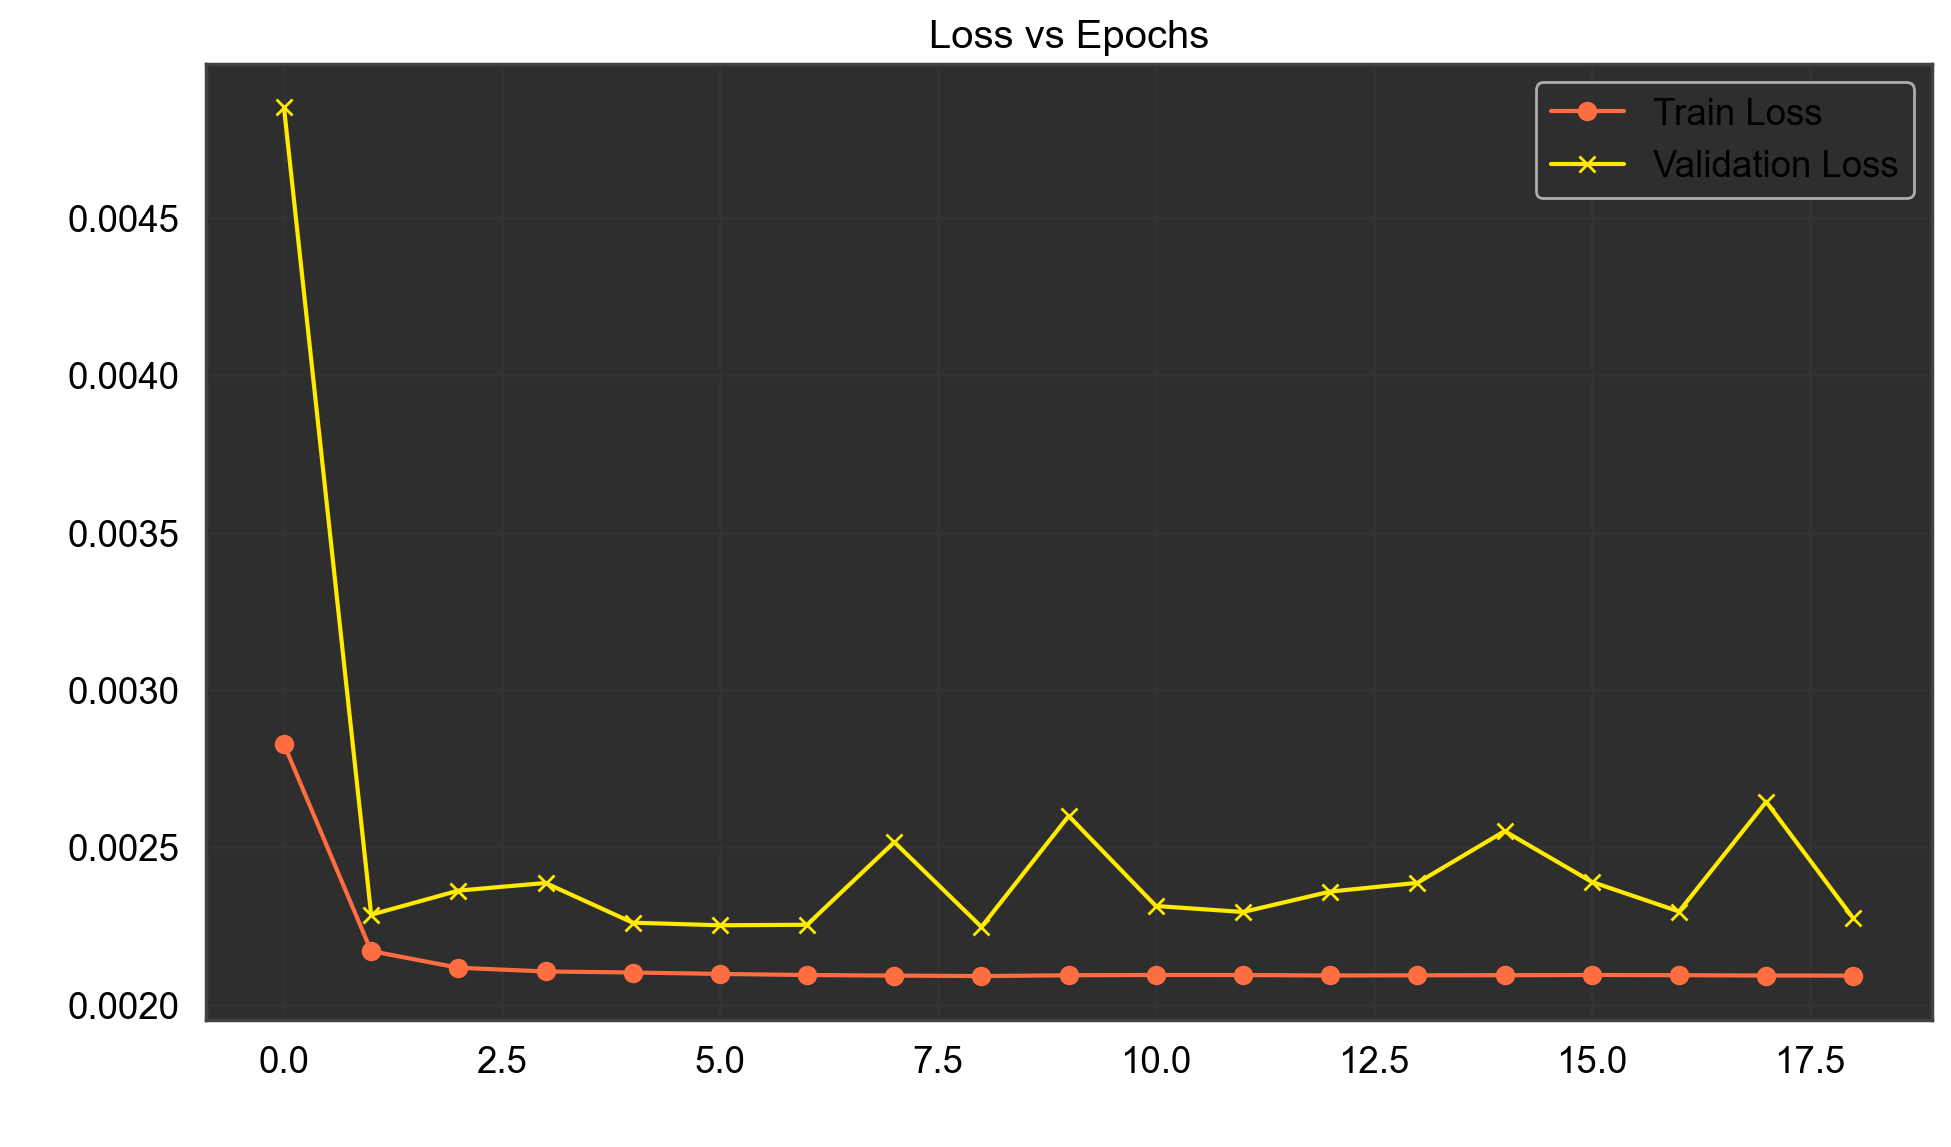

In [33]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [34]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_26812\1956403801.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

CNN_1D(
  (block1): Sequential(
    (0): Conv1d(13, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (4): Dropout(p=0.05, inplace=False)
  )
  (block2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (4): Dropout(p=0.05, inplace=False)
  )
  (block3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (4): Dropout(p=0.05, inplace=False)
  )
  (block4): Sequential(
    (0): Conv1d(128, 256, kernel_size=(5,), stri

In [35]:
evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_26812\1770941795.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint loaded from ck/CNN_1D_alibaba.pth


Evaluating: 100%|██████████| 3580/3580 [00:39<00:00, 89.99it/s] 



##### Evaluation Metrics #####
Test MAE         : 0.0359
Test RMSE        : 0.0514
Test Huber Loss  : 0.0013
Test MSE Loss    : 0.0026
Avg Inference Time per Sample: 0.0118 ms
Total Evaluation Time        : 2.71 seconds


(0.035890791565179825,
 np.float64(0.05142711988634463),
 0.001322480384260416,
 0.002644960768520832,
 0.011816185405116522)

#### LSTM DNN

In [36]:
class LSTM_DNN(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.lstm = nn.LSTM(input_size=features, hidden_size=64)
        self.dnn = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=64, out_features=32),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=forecast_horizon),
        )

    def forward(self, X):
        X = X.permute(1, 0, 2)
        _, (h, _) = self.lstm(X)
        y = self.dnn(h.squeeze(0))
        return y

In [37]:
model = LSTM_DNN(features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
lstm.weight_ih_l0                        [256, 13]                      3328
lstm.weight_hh_l0                        [256, 64]                      16384
lstm.bias_ih_l0                          [256]                          256
lstm.bias_hh_l0                          [256]                          256
dnn.1.weight                             [32, 64]                       2048
dnn.1.bias                               [32]                           32
dnn.3.weight                             [30, 32]                       960
dnn.3.bias                               [30]                           30
--------------------------------------------------------------------------------
Total Trainable Params                                                  23,294


In [38]:
checkpoint_path = "ck/LSTM_DNN_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 3580/3580 [00:48<00:00, 73.45it/s]


Epoch 01 | Train Loss: 0.0036 | Val Loss: 0.0033
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 3580/3580 [00:48<00:00, 73.33it/s]


Epoch 02 | Train Loss: 0.0023 | Val Loss: 0.0029
Checkpoint saved at epoch 2
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 3580/3580 [00:46<00:00, 76.70it/s] 


Epoch 03 | Train Loss: 0.0022 | Val Loss: 0.0027
Checkpoint saved at epoch 3


Epoch 4/100: 100%|██████████| 3580/3580 [00:49<00:00, 72.58it/s]


Epoch 04 | Train Loss: 0.0022 | Val Loss: 0.0025
Checkpoint saved at epoch 4
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 3580/3580 [01:02<00:00, 57.12it/s]


Epoch 05 | Train Loss: 0.0021 | Val Loss: 0.0026


Epoch 6/100: 100%|██████████| 3580/3580 [00:52<00:00, 67.91it/s]


Epoch 06 | Train Loss: 0.0021 | Val Loss: 0.0027
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 3580/3580 [00:37<00:00, 95.97it/s] 


Epoch 07 | Train Loss: 0.0021 | Val Loss: 0.0025
Checkpoint saved at epoch 7


Epoch 8/100: 100%|██████████| 3580/3580 [00:37<00:00, 96.29it/s] 


Epoch 08 | Train Loss: 0.0021 | Val Loss: 0.0024
Checkpoint saved at epoch 8
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 3580/3580 [00:41<00:00, 85.38it/s] 


Epoch 09 | Train Loss: 0.0021 | Val Loss: 0.0022
Checkpoint saved at epoch 9


Epoch 10/100: 100%|██████████| 3580/3580 [00:46<00:00, 76.72it/s]


Epoch 10 | Train Loss: 0.0021 | Val Loss: 0.0023
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 3580/3580 [00:45<00:00, 78.15it/s]


Epoch 11 | Train Loss: 0.0021 | Val Loss: 0.0022


Epoch 12/100: 100%|██████████| 3580/3580 [01:02<00:00, 57.34it/s]


Epoch 12 | Train Loss: 0.0021 | Val Loss: 0.0022
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 3580/3580 [01:02<00:00, 57.56it/s]


Epoch 13 | Train Loss: 0.0021 | Val Loss: 0.0022
Checkpoint saved at epoch 13


Epoch 14/100: 100%|██████████| 3580/3580 [00:45<00:00, 78.47it/s]


Epoch 14 | Train Loss: 0.0021 | Val Loss: 0.0023
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 3580/3580 [00:45<00:00, 78.53it/s]


Epoch 15 | Train Loss: 0.0021 | Val Loss: 0.0022
Checkpoint saved at epoch 15


Epoch 16/100: 100%|██████████| 3580/3580 [00:45<00:00, 77.93it/s]


Epoch 16 | Train Loss: 0.0021 | Val Loss: 0.0022
Checkpoint saved at epoch 16


Epoch 17/100: 100%|██████████| 3580/3580 [00:38<00:00, 93.41it/s] 


Epoch 17 | Train Loss: 0.0021 | Val Loss: 0.0022


Epoch 18/100: 100%|██████████| 3580/3580 [00:38<00:00, 93.76it/s] 


Epoch 18 | Train Loss: 0.0021 | Val Loss: 0.0022
Checkpoint saved at epoch 18


Epoch 19/100: 100%|██████████| 3580/3580 [00:52<00:00, 68.17it/s]


Epoch 19 | Train Loss: 0.0021 | Val Loss: 0.0022


Epoch 20/100: 100%|██████████| 3580/3580 [01:02<00:00, 57.25it/s]


Epoch 20 | Train Loss: 0.0021 | Val Loss: 0.0022
Checkpoint saved at epoch 20


Epoch 21/100: 100%|██████████| 3580/3580 [00:46<00:00, 77.22it/s]


Epoch 21 | Train Loss: 0.0021 | Val Loss: 0.0022


Epoch 22/100: 100%|██████████| 3580/3580 [00:45<00:00, 78.30it/s]


Epoch 22 | Train Loss: 0.0021 | Val Loss: 0.0022
Checkpoint saved at epoch 22


Epoch 23/100: 100%|██████████| 3580/3580 [00:45<00:00, 78.88it/s]


Epoch 23 | Train Loss: 0.0021 | Val Loss: 0.0022


Epoch 24/100: 100%|██████████| 3580/3580 [00:46<00:00, 77.62it/s]


Epoch 24 | Train Loss: 0.0021 | Val Loss: 0.0022
Checkpoint saved at epoch 24


Epoch 25/100: 100%|██████████| 3580/3580 [00:46<00:00, 77.59it/s]


Epoch 25 | Train Loss: 0.0021 | Val Loss: 0.0022
⚠️ Early stopping at epoch 25 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 2069.25 seconds
Best Validation Loss: 0.0022
Final Train Loss: 0.0021
Final Val Loss: 0.0022


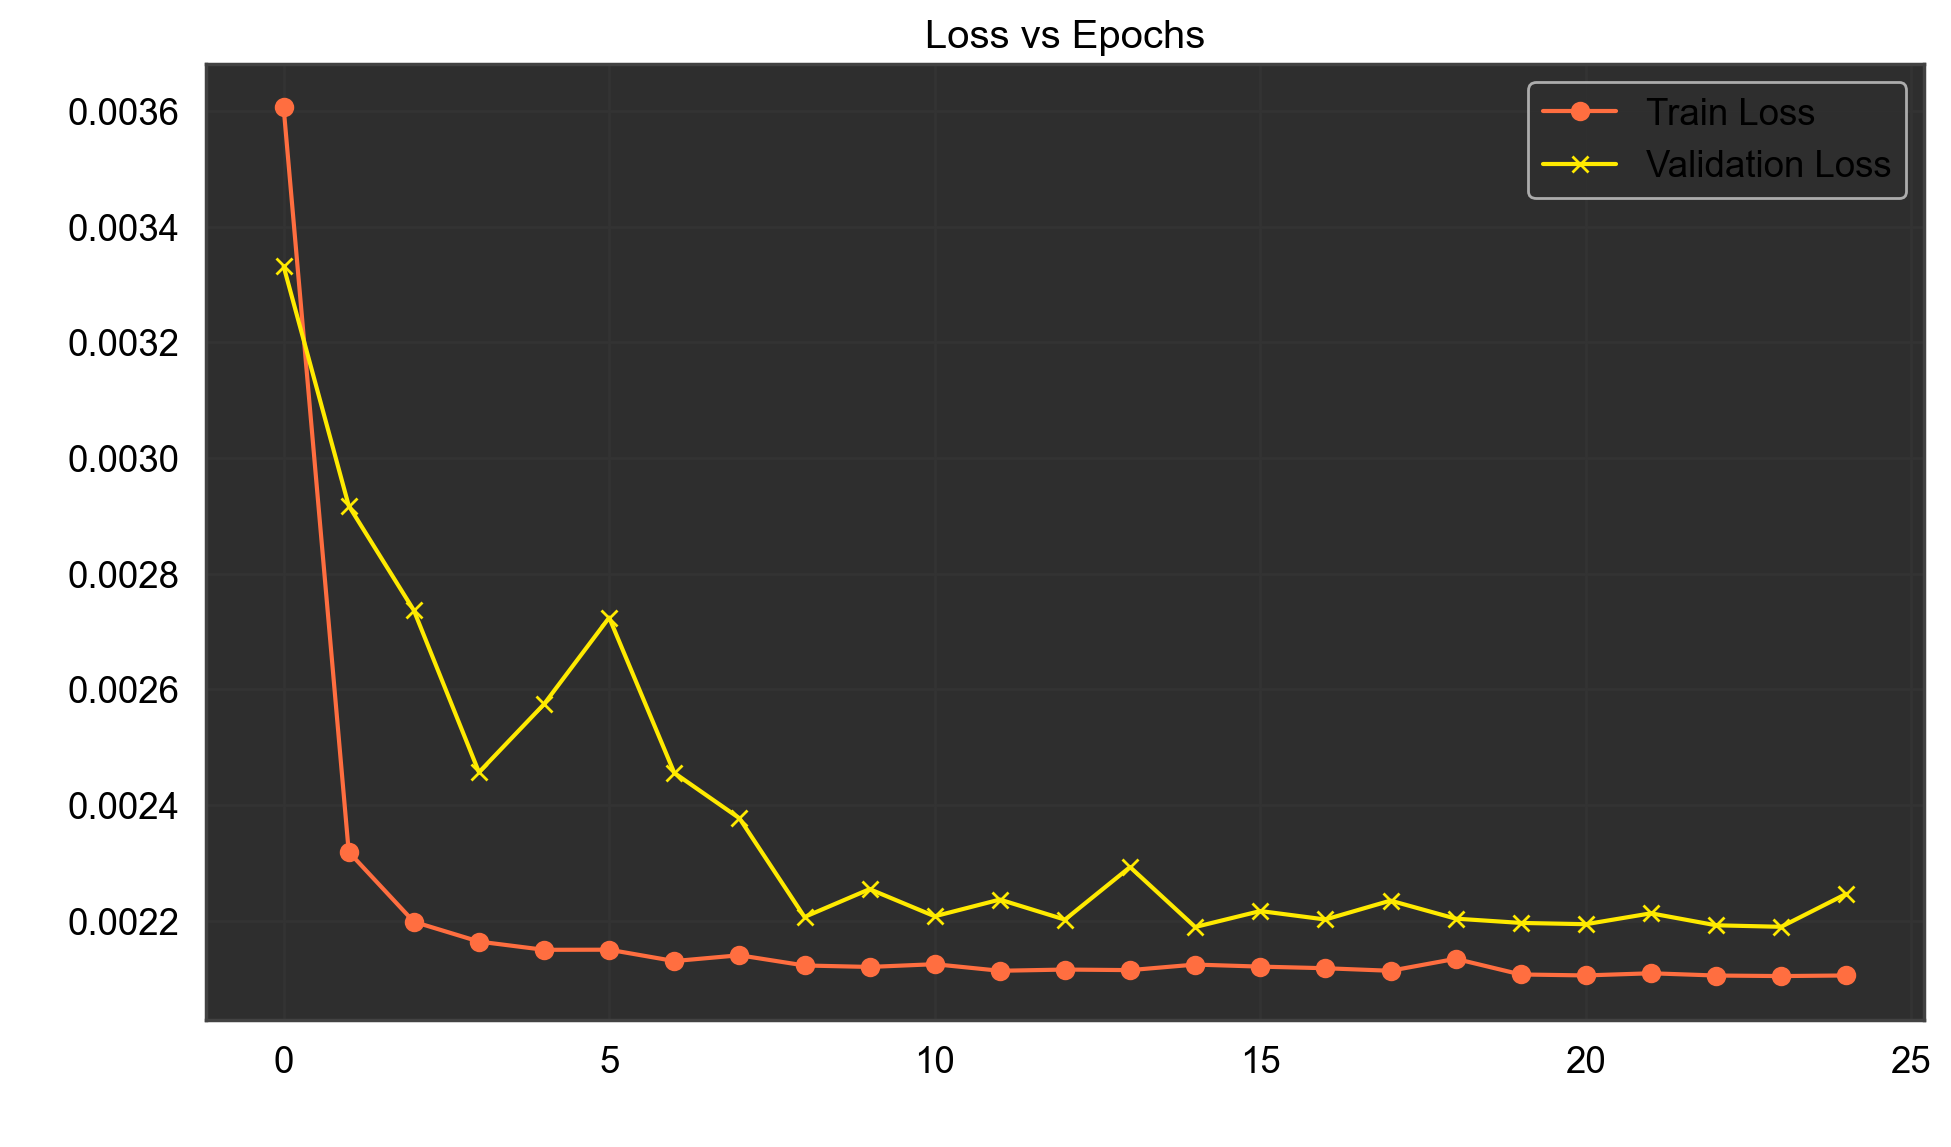

In [39]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [40]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_26812\1956403801.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

LSTM_DNN(
  (lstm): LSTM(13, 64)
  (dnn): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Tanh()
    (3): Linear(in_features=32, out_features=30, bias=True)
  )
)

In [41]:
evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_26812\1770941795.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint loaded from ck/LSTM_DNN_alibaba.pth


Evaluating: 100%|██████████| 3580/3580 [00:49<00:00, 72.73it/s]



##### Evaluation Metrics #####
Test MAE         : 0.0299
Test RMSE        : 0.0468
Test Huber Loss  : 0.0011
Test MSE Loss    : 0.0022
Avg Inference Time per Sample: 0.0041 ms
Total Evaluation Time        : 0.94 seconds


(0.029944319278001785,
 np.float64(0.04678906819417896),
 0.0010947233531624079,
 0.0021894467063248158,
 0.004094397259137055)

#### TCN

In [42]:
from torch.nn.utils import weight_norm
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.tanh1 = nn.Tanh()
        self.dropout1 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.tanh1, self.dropout1,
        )
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCN(nn.Module):
    def __init__(self, timesteps, features):
        super(TCN, self).__init__()

        self.tcn = TemporalConvNet(num_inputs=features, num_channels=[8, 16, 32], kernel_size=3)
        self.dnn = nn.Sequential(
            nn.Linear(in_features=timesteps*32, out_features=32),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=forecast_horizon),
        )

    def forward(self, X):
        X = X.permute(0,2,1)
        H = self.tcn(X)
        y = self.dnn(H.flatten(1))
        return y

In [43]:
# Initialize model and move it to GPU
model = TCN(timesteps, features).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
tcn.network.0.conv1.bias                 [8]                            8
tcn.network.0.conv1.weight_g             [8, 1, 1]                      8
tcn.network.0.conv1.weight_v             [8, 13, 3]                     312
tcn.network.0.downsample.weight          [8, 13, 1]                     104
tcn.network.0.downsample.bias            [8]                            8
tcn.network.1.conv1.bias                 [16]                           16
tcn.network.1.conv1.weight_g             [16, 1, 1]                     16
tcn.network.1.conv1.weight_v             [16, 8, 3]                     384
tcn.network.1.downsample.weight          [16, 8, 1]                     128
tcn.network.1.downsample.bias            [16]                           16
tcn.network.2.conv1.bias                 [32]                           32
tcn.network.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [44]:
checkpoint_path = "ck/TCN_model_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 3580/3580 [01:08<00:00, 52.29it/s]


Epoch 01 | Train Loss: nan | Val Loss: nan


Epoch 2/100: 100%|██████████| 3580/3580 [00:55<00:00, 64.44it/s]


Epoch 02 | Train Loss: nan | Val Loss: nan
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 3580/3580 [00:46<00:00, 77.16it/s]


Epoch 03 | Train Loss: nan | Val Loss: nan


Epoch 4/100: 100%|██████████| 3580/3580 [00:50<00:00, 71.45it/s]


Epoch 04 | Train Loss: nan | Val Loss: nan
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 3580/3580 [00:55<00:00, 64.95it/s]


Epoch 05 | Train Loss: nan | Val Loss: nan


Epoch 6/100: 100%|██████████| 3580/3580 [00:55<00:00, 64.62it/s]


Epoch 06 | Train Loss: nan | Val Loss: nan
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 3580/3580 [01:10<00:00, 50.63it/s]


Epoch 07 | Train Loss: nan | Val Loss: nan


Epoch 8/100: 100%|██████████| 3580/3580 [01:06<00:00, 53.98it/s]


Epoch 08 | Train Loss: nan | Val Loss: nan
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 3580/3580 [00:55<00:00, 64.84it/s]


Epoch 09 | Train Loss: nan | Val Loss: nan


Epoch 10/100: 100%|██████████| 3580/3580 [00:54<00:00, 66.23it/s]


Epoch 10 | Train Loss: nan | Val Loss: nan
⚠️ Early stopping at epoch 10 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 969.45 seconds
Best Validation Loss: inf
Final Train Loss: nan
Final Val Loss: nan


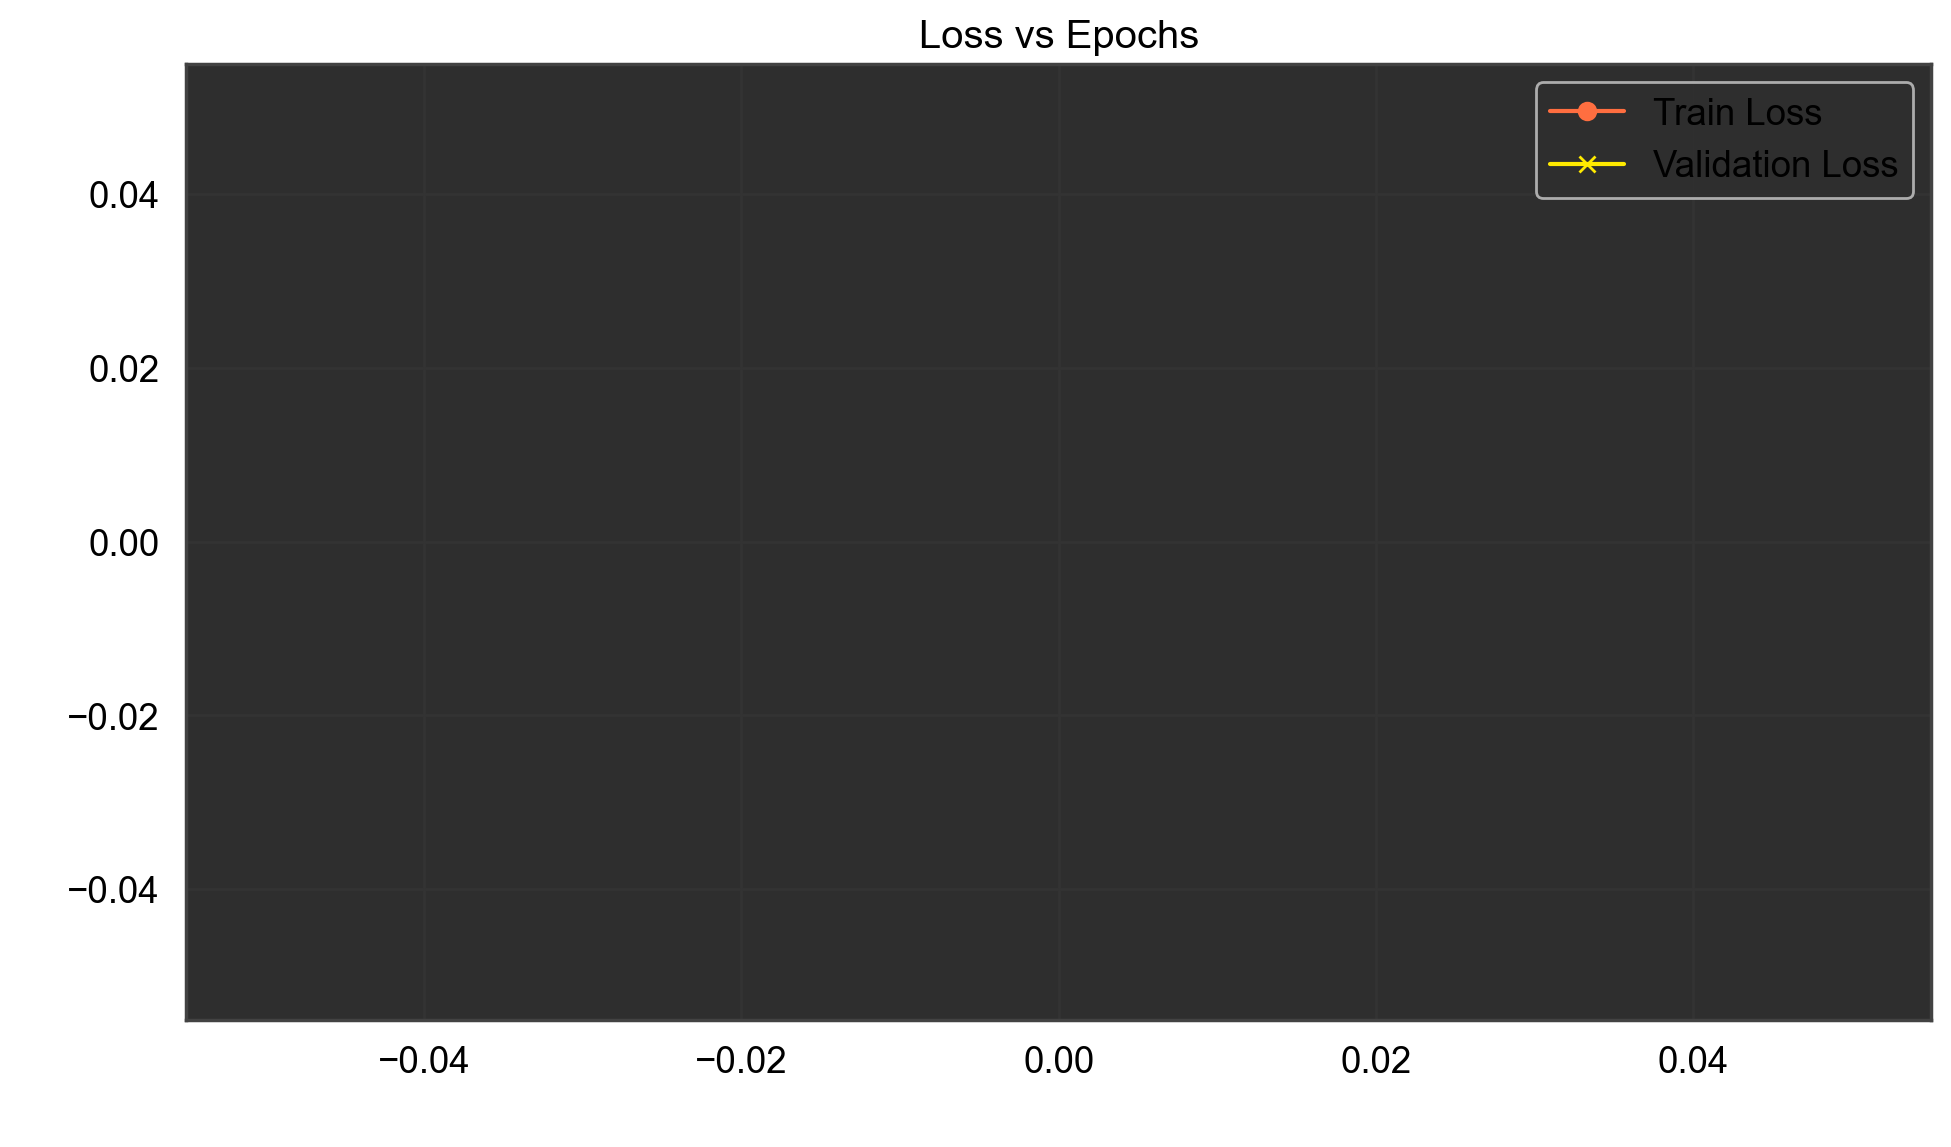

In [45]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [46]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_26812\1956403801.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(13, 8, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (tanh1): Tanh()
        (dropout1): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(13, 8, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): Tanh()
          (3): Dropout(p=0.2, inplace=False)
        )
        (downsample): Conv1d(13, 8, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
        (chomp1): Chomp1d()
        (tanh1): Tanh()
        (dropout1): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
          (1): Chomp1d()
          (2): Tanh()
          (3): Dropout(p=0.2, inplace=False)
        )


In [47]:
evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_26812\1770941795.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint loaded from ck/TCN_model_alibaba.pth


Evaluating: 100%|██████████| 3580/3580 [00:30<00:00, 116.86it/s]


ValueError: Input contains NaN.